In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd "drive/My Drive/Deep-Learning/Research/Beijing Housing Price/"

/content/drive/My Drive/Deep-Learning/Research/Beijing Housing Price


In [4]:
!pip3 install xgboost
!pip3 install lightgbm
!pip3 install vecstack

  Created wheel for vecstack: filename=vecstack-0.4.0-cp36-none-any.whl size=19879 sha256=aac0daf22823706b3a6a02b9b433ccc66cc30f8ad3862b8e3651f27416a7d79a
  Stored in directory: /root/.cache/pip/wheels/5f/bb/4e/f6488433d53bc0684673d6845e5bf11a25240577c8151c140e
Successfully built vecstack


In [0]:
#%% Import neccesary frameworks and libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import model_utils
import visual_utils
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import LinearSVR, SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from vecstack import stacking
from sklearn.preprocessing import StandardScaler, RobustScaler
plt.style.use('default') # Style 'ggplot' for white
import sklearn
import time
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import os

In [0]:
#%% Import dataset
df_train = pd.read_csv("ML_train.csv")
df_test = pd.read_csv("ML_test.csv")

In [0]:
df = pd.concat([df_train.drop(["price"], axis= 1), df_test.drop(["price"], axis= 1)], sort= False)
y = pd.concat([df_train["price"], df_test["price"]], axis= 0, sort= False)

In [0]:
#%% Feature Engineering
def addUsedTime(data):
  data["UsedTime"] = data["tradeTime"] - data["constructionTime"]
  return data
def commAvgDis(data):
  data["commAvgDis"] = data["communityAverage"] * data["distance"]
  return data
def groupDistrict(data):
  data["groupDistrict"] = data["district"]
  data["groupDistrict"] = data["groupDistrict"].replace([2, 7, 8, 9], 0)
  data["groupDistrict"] = data["groupDistrict"].replace([1, 4, 10], 2)
  data["groupDistrict"] = data["groupDistrict"].replace([5, 3, 11, 12, 6, 13], 1)
  return data
  
#df = addUsedTime(df)
#df = commAvgDis(df)
#df = groupDistrict(df)
df = df.drop(["url", "constructionTime"], axis= 1)
df = model_utils.nominal_encoder(df, features= ["renovationCondition", "buildingType", "buildingStructure", "district", "tradeTime", "floorType"])
df = model_utils.reorder_cols(df)

In [0]:
df.head(10)

,Lat,Lng,age,buildingStructure_1,buildingStructure_2,buildingStructure_4,buildingStructure_5,buildingStructure_6,buildingType_1,buildingType_2,buildingType_3,buildingType_4,communityAverage,distance,district_1,district_10,district_11,district_12,district_13,district_2,district_3,district_4,district_5,district_6,district_7,district_8,district_9,elevator,fiveYearsProperty,floorHeight,floorType_Bottom,floorType_High,floorType_Low,floorType_Middle,floorType_Top,floorType_Unknown,followers,ladderRatio,livingRoom,renovationCondition_1,renovationCondition_2,renovationCondition_3,renovationCondition_4,square,subway,tradeTime_2010,tradeTime_2011,tradeTime_2012,tradeTime_2013,tradeTime_2014,tradeTime_2015,tradeTime_2016,tradeTime_2017,tradeTime_2018
0,40.051164,116.605035,27,0,1,0,0,0,0,0,0,1,39605.0,0.246288,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6,0,0,0,0,1,0,2,0.500,2,1,0,0,0,57.25,0,0,0,0,0,0,1,0,0,0
1,39.978272,116.513137,14,0,0,0,0,1,0,0,0,1,73113.0,0.129101,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,9,0,1,0,0,0,0,1,0.250,1,1,0,0,0,57.85,0,0,0,0,1,0,0,0,0,0
2,39.893810,116.373903,20,0,0,0,0,1,1,0,0,0,79007.0,0.035071,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,19,0,1,0,0,0,0,20,0.250,2,0,0,1,0,81.23,1,0,0,0,0,0,1,0,0,0
3,39.949548,116.369634,21,0,1,0,0,0,0,0,0,1,90814.0,0.059015,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,1,0,0,0,0,0.500,2,1,0,0,0,60.00,1,0,0,0,1,0,0,0,0,0
4,39.906020,116.487301,15,0,0,0,0,1,1,0,0,0,66042.0,0.079922,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,28,0,0,0,1,0,0,1,0.286,2,1,0,0,0,68.51,1,0,0,1,0,0,0,0,0,0
5,40.118729,116.670101,21,0,1,0,0,0,0,0,0,1,34694.0,0.339167,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,0,0,1,0,0,0,0,0.500,2,0,0,0,1,85.95,0,0,0,0,0,0,1,0,0,0
6,39.934532,116.459113,15,0,0,0,0,1,1,0,0,0,73523.0,0.059952,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,25,0,0,0,1,0,0,0,0.214,1,1,0,0,0,53.49,1,0,0,1,0,0,0,0,0,0
7,40.168304,116.264021,9,0,0,0,0,1,0,0,1,0,38245.0,0.300514,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,17,0,0,0,1,0,0,20,0.500,2,0,0,1,0,86.97,0,0,0,0,0,0,0,0,1,0
8,39.827384,116.523423,9,0,0,0,0,1,0,0,1,0,49073.0,0.139148,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,9,0,0,1,0,0,0,5,0.333,2,1,0,0,0,67.27,0,0,0,0,0,0,1,0,0,0
9,40.051276,116.606151,21,0,1,0,0,0,0,0,0,1,38468.0,0.247252,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6,1,0,0,0,0,0,1,0.500,3,0,0,0,1,103.13,0,0,0,0,0,1,0,0,0,0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 4999
Data columns (total 54 columns):
Lat                      25000 non-null float64
Lng                      25000 non-null float64
age                      25000 non-null int64
buildingStructure_1      25000 non-null uint8
buildingStructure_2      25000 non-null uint8
buildingStructure_4      25000 non-null uint8
buildingStructure_5      25000 non-null uint8
buildingStructure_6      25000 non-null uint8
buildingType_1           25000 non-null uint8
buildingType_2           25000 non-null uint8
buildingType_3           25000 non-null uint8
buildingType_4           25000 non-null uint8
communityAverage         25000 non-null float64
distance                 25000 non-null float64
district_1               25000 non-null uint8
district_10              25000 non-null uint8
district_11              25000 non-null uint8
district_12              25000 non-null uint8
district_13              25000 non-null uint8
district_2

In [0]:
num_cols = ["Lat", "Lng", "age", "communityAverage", "distance", "floorHeight", "followers", "ladderRatio", "square"]

In [0]:
df[num_cols]

,Lat,Lng,age,communityAverage,distance,floorHeight,followers,ladderRatio,square
0,40.051164,116.605035,27,39605.0,0.246288,6,2,0.500,57.25
1,39.978272,116.513137,14,73113.0,0.129101,9,1,0.250,57.85
2,39.893810,116.373903,20,79007.0,0.035071,19,20,0.250,81.23
3,39.949548,116.369634,21,90814.0,0.059015,6,0,0.500,60.00
4,39.906020,116.487301,15,66042.0,0.079922,28,1,0.286,68.51
5,40.118729,116.670101,21,34694.0,0.339167,6,0,0.500,85.95
6,39.934532,116.459113,15,73523.0,0.059952,25,0,0.214,53.49
7,40.168304,116.264021,9,38245.0,0.300514,17,20,0.500,86.97
8,39.827384,116.523423,9,49073.0,0.139148,9,5,0.333,67.27
9,40.051276,116.606151,21,38468.0,0.247252,6,1,0.500,103.13


In [0]:
#%% Standardize Data
X_train = df.iloc[:20000,:]
y_train = y.iloc[:20000]
X_test = df.iloc[20000:,:]
y_test = y.iloc[20000:]
X_train_std = X_train.copy()
X_test_std = X_test.copy()
stdsc = StandardScaler()
X_train_std[num_cols] = stdsc.fit_transform(X_train[num_cols])
X_test_std[num_cols] = stdsc.transform(X_test[num_cols])

In [0]:
X_train_std = X_train_std.values
X_test_std = X_test_std.values 

In [0]:
X_train_std

array([[ 1.11186984,  1.60330915,  1.16468264, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.32825194,  0.80238924, -0.58624387, ...,  0.        ,
         0.        ,  0.        ],
       [-0.57974804, -0.41107875,  0.22187606, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.3901218 ,  1.81775816, -0.1821839 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.0707509 , -0.4970466 ,  0.22187606, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.43179976,  0.0572212 ,  1.70342926, ...,  0.        ,
         0.        ,  0.        ]])

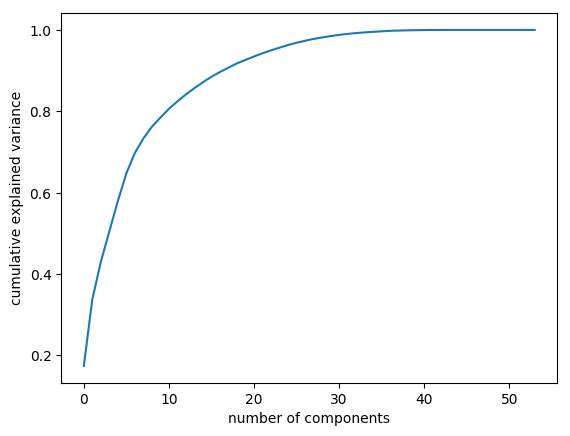

In [0]:
#%% PCA
pca = PCA(n_components= None)
pca.fit(X_train_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [0]:
#%% Machine Learning Models
model_name = []
model_error = []

In [0]:
# Lasso
'''
lasso = Lasso(alpha=100,precompute= True, copy_X= False, max_iter= 10,
            positive=True, random_state=5, selection='random', tol= 0.08)
(lasso_name, lasso_err)= model_utils.train_regressor(lasso, "Lasso", X_train_std, y_train)
model_name.append(lasso_name)
model_error.append(lasso_err)
'''

'\nlasso = Lasso(alpha=100,precompute= True, copy_X= False, max_iter= 10,\n            positive=True, random_state=5, selection=\'random\', tol= 0.08)\n(lasso_name, lasso_err)= model_utils.train_regressor(lasso, "Lasso", X_train_std, y_train)\nmodel_name.append(lasso_name)\nmodel_error.append(lasso_err)\n'

In [0]:
# Ridge
'''
ridge = Ridge(random_state=5)
(ridge_name, ridge_err)= model_utils.train_regressor(ridge, "Ridge", X_train_std, y_train)
model_name.append(ridge_name)
model_error.append(ridge_err)
'''

'\nridge = Ridge(random_state=5)\n(ridge_name, ridge_err)= model_utils.train_regressor(ridge, "Ridge", X_train_std, y_train)\nmodel_name.append(ridge_name)\nmodel_error.append(ridge_err)\n'

In [0]:
# KNN
'''
knr = KNeighborsRegressor(n_neighbors= 20, weights= "uniform")
(knr_name, knr_err)= model_utils.train_regressor(knr, "KNN", X_train_std, y_train)
model_name.append(knr_name)
model_error.append(knr_err)
'''

'\nknr = KNeighborsRegressor(n_neighbors= 20, weights= "uniform")\n(knr_name, knr_err)= model_utils.train_regressor(knr, "KNN", X_train_std, y_train)\nmodel_name.append(knr_name)\nmodel_error.append(knr_err)\n'

In [0]:
# Random Forest
rfr = RandomForestRegressor(n_estimators= 900, random_state= 5, max_features= "auto", min_samples_split= 10, max_depth= 20, bootstrap= True)
'''
(rfr_name, rfr_err) = model_utils.train_regressor(rfr, "Random Forest", X_train_std, y_train)
model_name.append(rfr_name)
model_error.append(rfr_err)
'''

'\n(rfr_name, rfr_err) = model_utils.train_regressor(rfr, "Random Forest", X_train_std, y_train)\nmodel_name.append(rfr_name)\nmodel_error.append(rfr_err)\n'

In [0]:
# SVR RBF
svr = SVR(C= 90000)

In [0]:
# LinearSVR
lsvr = LinearSVR(C= 15, max_iter= 50000)
'''
(lsvr_name, lsvr_err) = model_utils.train_regressor(lsvr, "LinearSVR", X_train_std, y_train)
model_name.append(lsvr_name)
model_error.append(lsvr_err)
'''

'\n(lsvr_name, lsvr_err) = model_utils.train_regressor(lsvr, "LinearSVR", X_train_std, y_train)\nmodel_name.append(lsvr_name)\nmodel_error.append(lsvr_err)\n'

In [0]:
# XGBoost
xgb = XGBRegressor(max_depth=7, learning_rate=0.1, n_jobs=-1, nthread=-1, 
                    gamma=0.5, min_child_weight=2,
                    subsample=1, colsample_bytree=0.8, 
                    reg_alpha=0, reg_lambda=0.45, n_estimators= 200, 
                    random_state=5)
'''
(xgb_name, xgb_err) = model_utils.train_regressor(xgb, "XGBoost", X_train_std, y_train)
model_name.append(xgb_name)
model_error.append(xgb_err)
'''

'\n(xgb_name, xgb_err) = model_utils.train_regressor(xgb, "XGBoost", X_train_std, y_train)\nmodel_name.append(xgb_name)\nmodel_error.append(xgb_err)\n'

In [0]:
# Light GBM
lgbm = LGBMRegressor(num_leaves= 36, learning_rate=0.15, min_child_weight= 2,
                     max_depth = 7, colsample_bytree= 0.8,
                      n_estimators=64, reg_lambda= 0.4, random_state=5, n_jobs=-1)
'''
(lgbm_name, lgbm_err) = model_utils.train_regressor(lgbm, "Light GBM", X_train_std, y_train)
model_name.append(lgbm_name)
model_error.append(lgbm_err)
'''

'\n(lgbm_name, lgbm_err) = model_utils.train_regressor(lgbm, "Light GBM", X_train_std, y_train)\nmodel_name.append(lgbm_name)\nmodel_error.append(lgbm_err)\n'

In [0]:
#%% Parameters Tuning
'''
param_grid= {
    "num_leaves": [34, 36, 38, 40],
    "max_depth": [-1, 4, 5, 6, 7, 8, 9],
    "learning_rate": [0.01, 0.1, 0.15, 0.2, 0.3, 0.4],
    "n_estimators": [58, 60, 62, 64, 66, 68, 70],
    "min_child_weight": [0.5, 1, 2, 3, 4],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "reg_lambda": [0.2, 0.3, 0.4, 0.45, 0.5]
}

sr = RandomizedSearchCV(lgbm, param_grid, scoring= "neg_mean_squared_log_error", cv= 5, n_iter= 100)
sr.fit(X_train_std, y_train)

best_params = sr.best_params_
print(best_params)
'''

'\nparam_grid= {\n    "num_leaves": [34, 36, 38, 40],\n    "max_depth": [-1, 4, 5, 6, 7, 8, 9],\n    "learning_rate": [0.01, 0.1, 0.15, 0.2, 0.3, 0.4],\n    "n_estimators": [58, 60, 62, 64, 66, 68, 70],\n    "min_child_weight": [0.5, 1, 2, 3, 4],\n    "colsample_bytree": [0.6, 0.7, 0.8, 0.9],\n    "reg_lambda": [0.2, 0.3, 0.4, 0.45, 0.5]\n}\n\nsr = RandomizedSearchCV(lgbm, param_grid, scoring= "neg_mean_squared_log_error", cv= 5, n_iter= 100)\nsr.fit(X_train_std, y_train)\n\nbest_params = sr.best_params_\nprint(best_params)\n'

In [0]:
#visual_utils.plot_validation_curve(lsvr, 'epsilon', [0, 0.001, 0.01, 0.1, 10, 100, 1000], X_train_std,
#                      y_train, scoring= "neg_mean_squared_error", xscale= True)

In [0]:
# visual_utils.compare_regressors(model_name, model_error)

In [0]:
#%% Voting Regressor
'''
vr = VotingRegressor([('xgb', xgb), ('lgbm', lgbm), ('rfr', rfr)])
(vr_name, vr_err)= model_utils.train_regressor(vr, "VotingRegressor", X_train_std, y_train)
'''

'\nvr = VotingRegressor([(\'xgb\', xgb), (\'lgbm\', lgbm), (\'rfr\', rfr)])\n(vr_name, vr_err)= model_utils.train_regressor(vr, "VotingRegressor", X_train_std, y_train)\n'

In [0]:

#%% Model Stacking
'''
X_train, X_val, y_train, y_val = train_test_split(X_train_std, y_train, test_size= 0.2)
models = [lgbm, rfr] # 1st level models
S_train, S_val = stacking(models,
                           X_train, y_train, X_val,
                           regression=True,
                           mode='oof_pred_bag',
                           n_folds=5,
                           save_dir=None,
                           needs_proba=False,
                           random_state=5,
                           shuffle=True,
                           verbose=2,
                          )
xgb.fit(S_train, y_train)
stacked_pred = xgb.predict(S_val)

print("Final Prediction Score: %f" %np.sqrt(mean_squared_log_error(y_val, stacked_pred)))
'''

'\nX_train, X_val, y_train, y_val = train_test_split(X_train_std, y_train, test_size= 0.2)\nmodels = [lgbm, rfr] # 1st level models\nS_train, S_val = stacking(models,\n                           X_train, y_train, X_val,\n                           regression=True,\n                           mode=\'oof_pred_bag\',\n                           n_folds=5,\n                           save_dir=None,\n                           needs_proba=False,\n                           random_state=5,\n                           shuffle=True,\n                           verbose=2,\n                          )\nxgb.fit(S_train, y_train)\nstacked_pred = xgb.predict(S_val)\n\nprint("Final Prediction Score: %f" %np.sqrt(mean_squared_log_error(y_val, stacked_pred)))\n'

In [0]:
lsvr.fit(X_train_std, y_train)
rfr.fit(X_train_std, y_train)
xgb.fit(X_train_std, y_train)
lgbm.fit(X_train_std, y_train)
lsvr_pred_train = lsvr.predict(X_train_std)
rfr_pred_train = rfr.predict(X_train_std)
xgb_pred_train = xgb.predict(X_train_std)
lgbm_pred_train = lgbm.predict(X_train_std)
lsvr_pred_test = lsvr.predict(X_test_std)
rfr_pred_test = rfr.predict(X_test_std)
xgb_pred_test = xgb.predict(X_test_std)
lgbm_pred_test = lgbm.predict(X_test_std)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[22:24:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [13]:
lsvr.fit(X_train_std, y_train)
lsvr_pred_train = lsvr.predict(X_train_std)
lsvr_pred_test = lsvr.predict(X_test_std)

NameError: ignored

In [21]:
svr.fit(X_train_std, y_train)
svr_pred_train = svr.predict(X_train_std)
svr_pred_test = svr.predict(X_test_std)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [19]:
#%% SVR
print("Train Loss: %f" %np.sqrt(mean_squared_log_error(y_train, svr_pred_train)))
print("Test Loss: %f" %np.sqrt(mean_squared_log_error(y_test, svr_pred_test)))

Train Loss: 0.453899
Test Loss: 0.459251


In [0]:
#%% Linear SVR
print("Train Loss: %f" %np.sqrt(mean_squared_log_error(y_train, lsvr_pred_train)))
print("Test Loss: %f" %np.sqrt(mean_squared_log_error(y_test, lsvr_pred_test)))

Train Loss: 0.220862
Test Loss: 0.220244


In [0]:
#%% Random Forest Result
print("Train Loss: %f" %np.sqrt(mean_squared_log_error(y_train, rfr_pred_train)))
print("Test Loss: %f" %np.sqrt(mean_squared_log_error(y_test, rfr_pred_test)))

Train Loss: 0.122388
Test Loss: 0.181063


In [0]:
#%% Light GBM
print("Train Loss: %f" %np.sqrt(mean_squared_log_error(y_train, lgbm_pred_train)))
print("Test Loss: %f" %np.sqrt(mean_squared_log_error(y_test, lgbm_pred_test)))

Train Loss: 0.169385
Test Loss: 0.177441


In [0]:
#%% XGBoost
print("Train Loss: %f" %np.sqrt(mean_squared_log_error(y_train, xgb_pred_train)))
print("Test Loss: %f" %np.sqrt(mean_squared_log_error(y_test, xgb_pred_test)))

Train Loss: 0.137840
Test Loss: 0.174538


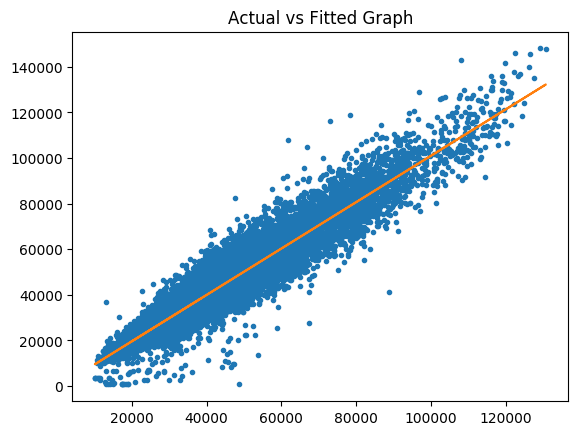

In [0]:
visual_utils.actual_fitted_graph(lgbm_pred, y_train)

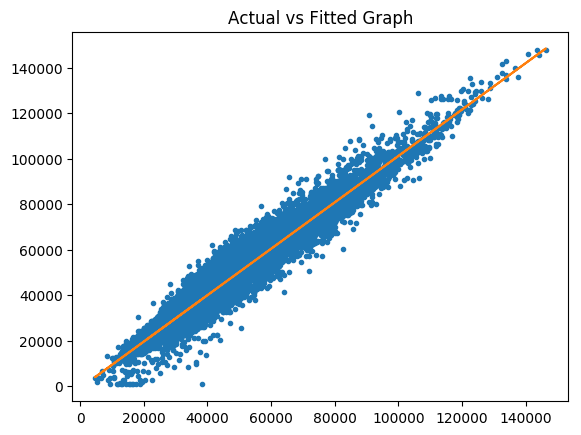

In [0]:
visual_utils.actual_fitted_graph(xgb_pred, y_train)

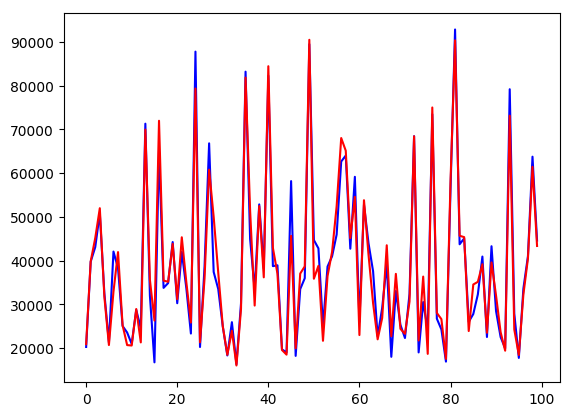

In [0]:
plt.plot(y_train[:100], color = 'blue')
plt.plot(xgb_pred[:100], color = 'red')

In [0]:
a = df_train["square"]

In [0]:
a.shape

(20000,)

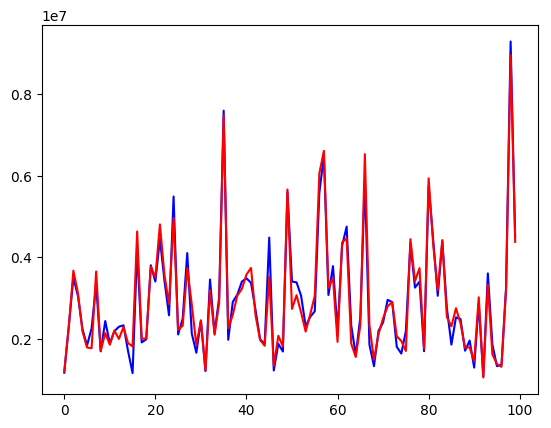

In [0]:
plt.plot((y_train*a)[:100], color = 'blue')
plt.plot((xgb_pred*a)[:100], color = 'red')